# Implementação da avaliação de modelos de classificação

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%autosave 2

Autosaving every 2 seconds


In [9]:
dataset = pd.read_csv('../dataset_bacteria.csv')
dataset['volumecorpo'] = np.array(dataset['comprimentocorpo']) * np.pi*(np.array(dataset['larguracorpo'])/2)**2
dataset['volumeflagelo'] = np.array(dataset['comprimentoflagelo']) * np.pi*(np.array(dataset['larguraflagelo'])/2)**2
print(dataset.columns.values)

['comprimentocorpo' 'larguracorpo' 'comprimentoflagelo' 'larguraflagelo'
 'Tipo' 'volumecorpo' 'volumeflagelo']


### Criando conjunto de teste e conjunto de treinamento

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib # biblioteca para salvar os modelos

Y = dataset.iloc[:, 4].values # Coluna Tipo
X = dataset.iloc[:, [2, 3]].values # Features Selecionadas

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

### Criação do Modelo de classificação KNN

In [20]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier(5, 'uniform')
knn_classifier.fit(x_train, y_train);

# Saving model to file
# joblib.dump(knn_classifier, '../knnBacteria.sav')

### Criação do Modelo de Classificação SVM

In [21]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel = 'rbf', gamma = 0.1)
svm_classifier.fit(x_train, y_train);

# Saving model to file
#joblib.dump(svm_classifier, '../svmBacteria.sav')

### Criando dataset de treinamento e teste

In [29]:
X_svm = dataset.iloc[:, [1, 3]].values # Features Selecionadas

x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, Y, test_size = 0.25)

### Importando modelos para avaliação

In [30]:
from sklearn.metrics import confusion_matrix

# Importando modelo KNN
knn_model = joblib.load('../Modelos/knnBacteria.sav')
knn_y_pred = knn_model.predict(x_test)

knn_confusion_matrix = confusion_matrix(y_test, knn_y_pred)
print(knn_confusion_matrix)

# Importando modelo SVM
svm_model = joblib.load('../Modelos/svmBacteria.sav')
svm_y_pred = svm_model.predict(x_test_svm)

svm_confusion_matrix = confusion_matrix(y_test_svm, svm_y_pred)
print('\n', svm_confusion_matrix)

[[15  0  0]
 [ 0 10  1]
 [ 0  0 12]]

 [[15  0  0]
 [ 0 10  0]
 [ 0  2 11]]


## Avaliando modelos

#### Pelo método de _micro-averaging_ e _macro-averaging_ [1]

Baseando-se pela matrix de confusão, pode-se calcular a precisão micro e precisão macro com a seguinte estratégia:

Tomando a matriz de confusão como a abaixo:
![img](https://qph.ec.quoracdn.net/main-qimg-e73665ad4501b9da6d5611e7b6d8e7a2 "Matriz de Confusão")

Podemos calcular a precisão do modelo com a seguinte fórmula:
$$ PRE = \frac{TP} {(TP + FP)} $$

E então generalizar a matriz de confusão de classificação binária para uma classificação multi-classe. Onde o calculo da _micro-average_ calcula a performance e precisão e a _macro-average_ calcula a média das performances de cada classe individualmente.

Para a _micro-averaging_ utilizamos a fórmula:
$$ PRE_{micro} = \frac{TP_1 + ... + TP_n} {TP_1 + ... + TP_n + FP_1 + ... + FP_n} $$

E para a _macro-averaging_ utilizamos a seguinte fórmula:
$$ PRE_{macro} = \frac{PRE_1 + ... + PRE_n} {n} $$


---
[1] Quora answer, Sebastian Raschka: [What are some good error metrics for multi-class classification when you have many objects to classify?](https://www.quora.com/What-are-some-good-error-metrics-for-multi-class-classification-when-you-have-many-objects-to-classify)   

---

In [31]:
# Função para calcular o valor da precisão micro e macro
def evaluation_micro_macro (confusion_matrix):
    TP_all = 0
    FP_all = 0
    pre_all = 0
    n_classes = confusion_matrix.shape[0]
    for i in range(n_classes):
        TP_all += confusion_matrix[i][i]
        next_row = (i + 1) % n_classes
        FP_all += confusion_matrix[i][next_row]
        last_row = (i + 2) % n_classes
        FP_all += confusion_matrix[i][last_row]
        pre_all += confusion_matrix[i][i] / (confusion_matrix[i][i] + confusion_matrix[i][next_row] + knn_confusion_matrix[i][last_row])

    pre_micro = TP_all / (TP_all + FP_all)
    pre_macro = pre_all / n_classes
    
    return (pre_micro, pre_macro)

In [32]:
# Avaliando o modelo KNN pela estratégia de micro e macro averaging
mi_knn, ma_knn = evaluation_micro_macro(knn_confusion_matrix)

# Avaliando o modelo SVM pela estratégia de micro e macro averaging
mi_svm, ma_svm = evaluation_micro_macro(svm_confusion_matrix)

# Utilizando o macro-averaging podemos escolher o melhor método
# Já que o macro-averaging nos da um peso igual da classificação de cada classe
print ('Melhor modelo de classificação', 'KNN' if ma_knn > ma_svm else 'SVM')

Melhor modelo de classificação SVM


### Pelo método de cálculo embaixo da curva ROC (_Receiving Operating Characteristic_)

**ROC** significa, em tradução livre, Características operacionais do receptor, e sua curva nada mais é que a demonstração gráfica que ilustra a habilidade do diagnóstico de um sistema de classificador binário, dessa forma pode-se inspecionar a performance do classificador.

Esse método compara a taxa em que o classificador está fazendo predições corretas (Positivos verdadeiros) e a taxa em que o classificador está dando alarmes falsos (Falsos positivos). Para achar a taxa de positivos verdadeiros e falsos positivos, utilizamos a seguinte fórmula:

$$ TPR = \frac {TruePositives} {(TruePositives + FalseNegatives)} $$

$$ FPR = \frac {FalsePositives} {(FalsePositives + TrueNegatives)} $$

Onde $TPR$ é a nossa taxa de positivos verdadeiros e $FPR$ a de falsos positivos. Com isso podemos medir corretamente o _trade off_ da taxa em que o classificador consegue predizer corretamente algo com a taxa em que ele erra em sua predição.

Para entender a curva ROC temos primeiro que definir o que é um bom resultado para um classificador. Um classificador que faz predições ao acaso (aleátoriamente), consegue estar correto apenas 50% do tempo (lembrando que estamos falando de classificadores binários), dessa forma o gráfico de predição desse classificador seria uma reta diagonal. 
![classificador random](http://blog.yhat.com/static/img/roc-guessing.png 'classificador aleatório')

Então podemos dizer que qualquer outra curva que esteja acima dessa é uma melhora de um classificador, e qualquer curva abaixo disso está fazendo um desserviço ao usuário. 

Sendo assim podemos também dizer o que seria um classificador perfeito. 
![](http://blog.yhat.com/static/img/roc-perfect.png 'Classificador Perfeito')

Então quanto mais a curva do seu classificador se aproximar a essa, melhor será, porém em aprendizado de máquina deve sempre se ter cuidado com _overfitting_. Dessa forma, um bom classificador se parecerá com isso:
![](http://blog.yhat.com/static/img/roc-pretty-good.png 'Bom Classificador')

Agora para se calcular o quão bom ou ruim um classificador é calculamos a área embaixo da curva. E para comparar os classificadores basta comparar os valores embaixo da curva _ROC_. 
![](http://blog.yhat.com/static/img/roc-auc.png 'Área da curva ROC')

---
Lembrando que esse método foi pensado para classificadores binários, sendo assim para usa-lo em um classificador de multi-classes é necessário binarizar a saída. Uma curva pode ser desenhada por classe, mas uma também pode desenhar uma curva considerando cada elemento da matriz indicadora de classes como uma predição binária (_micro-averaging_).

[Multi-class ROC curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [9]:
# Calculando a área da curva ROC 

from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

knn_model = joblib.load('../Modelos/knnBacteria.sav')
svm_model = joblib.load('../Modelos/svmBacteria.sav')



## Cross Validation

Cross Validation é um método que divide o dado disponível em K partes mutualmente exclusivas e calcula a acurância para cada um deles, abaixo temos uma implementação que mostra a média e desvio padrão de cada modelo bem como a plotagem desses dados.

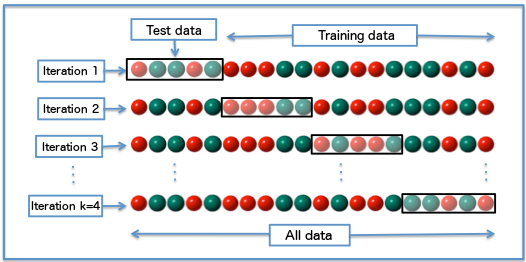

Detalhes sobre a plotagem: essa plotagem se chama "boxplot", as linhas superiores e inferiores mostram a extensão dos dados, a caixa inferior e superior representa o menor e o maior valor de predição enquanto a linha vermelha representa a média do modelo.

SVC: 0.966667 (0.033333)
KNN: 0.960000 (0.032660)


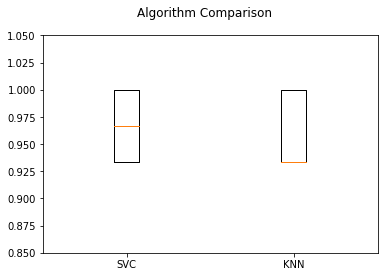

In [33]:
from sklearn import model_selection

models=[]
results=[]
names=[]
models.append(['SVC',svm_model])
models.append(['KNN',knn_model])

for name, model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=2)
    m_results= model_selection.cross_val_score(model,X,Y,cv=kfold,scoring='accuracy')

    names.append(name)
    results.append(m_results)
    print("%s: %f (%f)" % (name, m_results.mean(), m_results.std()))
    
    fig = plt.figure()

    
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim([0.85,1.05])
plt.show()


